In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: '%.6f' % x)

In [2]:
data_types = {
         'Store': np.dtype(int),
         'DayOfWeek': np.dtype(int),
         #'Date': np.dtype(str),
         'Sales': np.dtype(int),
         'Customers': np.dtype(int),
         #'Open': np.dtype('float64'),
         'Promo': np.dtype(int),
         'StateHoliday': np.dtype(str),
         'SchoolHoliday': np.dtype(int)
         }

store_data_types = {
         'Store': np.dtype(int),
         'StoreType': np.dtype(str),
         'Assortment': np.dtype(str),
         #'CompetitionDistance': np.dtype('float64'),
         'CompetitionOpenSinceMonth': np.dtype('str'),
         'CompetitionOpenSinceYear': np.dtype('str'),
         'Promo2': np.dtype(int),
         'Promo2SinceWeek': np.dtype('str'),
         'Promo2SinceYear': np.dtype('str'),
         'PromoInterval': np.dtype(str)
        }

pre_train = pd.read_csv("input/train.csv", parse_dates=[2], dtype=data_types)
pre_test = pd.read_csv("input/test.csv", parse_dates=[3], dtype=data_types)
store = pd.read_csv("input/store.csv", dtype=store_data_types)

In [6]:
print('- Train data')
print(pre_train.dtypes)

- Train data
Store                     int32
DayOfWeek                 int32
Date             datetime64[ns]
Sales                     int32
Customers                 int32
Open                      int64
Promo                     int32
StateHoliday             object
SchoolHoliday             int32
dtype: object


In [7]:
print('- Train data')
print(pre_train.dtypes)

- Train data
Store                     int32
DayOfWeek                 int32
Date             datetime64[ns]
Sales                     int32
Customers                 int32
Open                      int64
Promo                     int32
StateHoliday             object
SchoolHoliday             int32
dtype: object


In [176]:
print('- Store data')
print(store.dtypes)

- Store data
Store                          int32
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int32
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object


# Data pre-processing

In [9]:
pre_train.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1017209.000000,1017209.000000,1017209.000000,1017209.000000,1017209.000000,1017209.000000,1017209.000000
mean,558.429727,3.998341,5773.818972,633.145946,0.830107,0.381515,0.178647
std,321.908651,1.997391,3849.926175,464.411734,0.375539,0.485759,0.383056
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,280.000000,2.000000,3727.000000,405.000000,1.000000,0.000000,0.000000
50%,558.000000,4.000000,5744.000000,609.000000,1.000000,0.000000,0.000000
75%,838.000000,6.000000,7856.000000,837.000000,1.000000,1.000000,0.000000
max,1115.000000,7.000000,41551.000000,7388.000000,1.000000,1.000000,1.000000


In [10]:
pre_test.describe()

,Id,Store,DayOfWeek,Open,Promo,SchoolHoliday
count,41088.000000,41088.000000,41088.000000,41077.000000,41088.000000,41088.000000
mean,20544.500000,555.899533,3.979167,0.854322,0.395833,0.443487
std,11861.228267,320.274496,2.015481,0.352787,0.489035,0.496802
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,10272.750000,279.750000,2.000000,1.000000,0.000000,0.000000
50%,20544.500000,553.500000,4.000000,1.000000,0.000000,0.000000
75%,30816.250000,832.250000,6.000000,1.000000,1.000000,1.000000
max,41088.000000,1115.000000,7.000000,1.000000,1.000000,1.000000


In [11]:
store.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.000000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.000000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.017080,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.000000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.500000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.000000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.500000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.000000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


In [12]:
pre_train.nunique()

Store             1115
DayOfWeek            7
Date               942
Sales            21734
Customers         4086
Open                 2
Promo                2
StateHoliday         4
SchoolHoliday        2
dtype: int64

In [13]:
pre_test.nunique()

Id               41088
Store              856
DayOfWeek            7
Date                48
Open                 2
Promo                2
StateHoliday         2
SchoolHoliday        2
dtype: int64

In [14]:
store.nunique()

Store                        1115
StoreType                       4
Assortment                      3
CompetitionDistance           654
CompetitionOpenSinceMonth      12
CompetitionOpenSinceYear       23
Promo2                          2
Promo2SinceWeek                24
Promo2SinceYear                 7
PromoInterval                   3
dtype: int64

In [15]:
# All test stores are also in the train data
np.count_nonzero(np.isin(pre_test.Store.unique(), pre_train.Store.unique()))

856

In [16]:
# 259 store in train data are not in test data
pre_train.Store.nunique() - np.count_nonzero(np.isin(pre_test.Store.unique(), pre_train.Store.unique()))

259

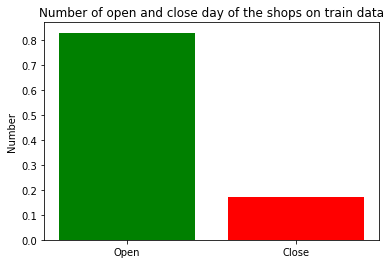

In [17]:
objects = ('Open', 'Close')
y_pos = np.arange(len(objects))
length_data = [len(pre_train.Open[pre_train["Open"] == 1])/len(pre_train.Open), len(pre_train.Open[pre_train["Open"] == 0])/len(pre_train.Open)]
 
plt.bar(y_pos, length_data, align='center', alpha=1, color=['green','red'])
plt.xticks(y_pos, objects)
plt.ylabel('Number')
plt.title('Number of open and close day of the shops on train data')
 
plt.show()

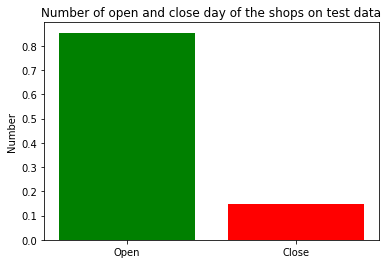

In [18]:
objects = ('Open', 'Close')
y_pos = np.arange(len(objects))
length_data = [len(pre_test.Open[pre_test["Open"] == 1])/len(pre_test.Open), len(pre_test.Open[pre_test["Open"] == 0])/len(pre_test.Open)]
 
plt.bar(y_pos, length_data, align='center', alpha=1, color=['green','red'])
plt.xticks(y_pos, objects)
plt.ylabel('Number')
plt.title('Number of open and close day of the shops on test data')
 
plt.show()

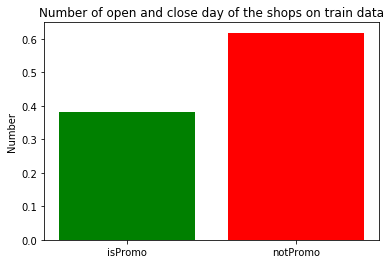

In [19]:
objects = ('isPromo', 'notPromo')
y_pos = np.arange(len(objects))
length_data = [len(pre_train.Open[pre_train["Promo"] == 1])/len(pre_train.Open), len(pre_train.Open[pre_train["Promo"] == 0])/len(pre_train.Open)]
 
plt.bar(y_pos, length_data, align='center', alpha=1, color=['green','red'])
plt.xticks(y_pos, objects)
plt.ylabel('Number')
plt.title('Number of open and close day of the shops on train data')
 
plt.show()

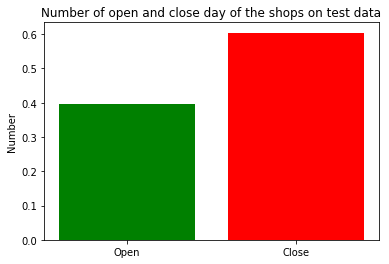

In [20]:
objects = ('Open', 'Close')
y_pos = np.arange(len(objects))
length_data = [len(pre_test.Open[pre_test["Promo"] == 1])/len(pre_test.Open), len(pre_test.Open[pre_test["Promo"] == 0])/len(pre_test.Open)]
 
plt.bar(y_pos, length_data, align='center', alpha=1, color=['green','red'])
plt.xticks(y_pos, objects)
plt.ylabel('Number')
plt.title('Number of open and close day of the shops on test data')
 
plt.show()

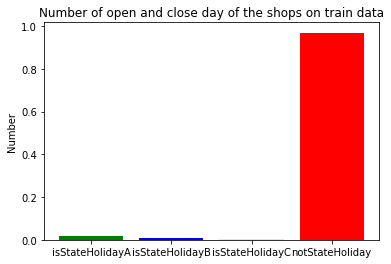

In [21]:
objects = ('isStateHolidayA', 'isStateHolidayB', 'isStateHolidayC', 'notStateHoliday')
y_pos = np.arange(len(objects))
length_data = [len(pre_train.Open[pre_train["StateHoliday"] == 'a'])/len(pre_train.Open), 
               len(pre_train.Open[pre_train["StateHoliday"] == 'b'])/len(pre_train.Open), 
               len(pre_train.Open[pre_train["StateHoliday"] == 'c'])/len(pre_train.Open), 
               len(pre_train.Open[pre_train["StateHoliday"] == '0'])/len(pre_train.Open)]
 
plt.bar(y_pos, length_data, align='center', alpha=1, color=['green', 'blue', 'yellow', 'red'])
plt.xticks(y_pos, objects)
plt.ylabel('Number')
plt.title('Number of open and close day of the shops on train data')
 
plt.show()

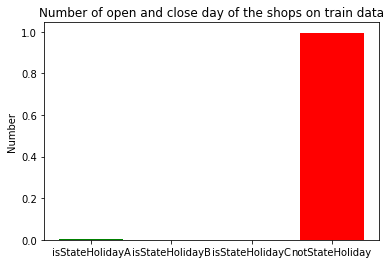

In [22]:
objects = ('isStateHolidayA', 'isStateHolidayB', 'isStateHolidayC', 'notStateHoliday')
y_pos = np.arange(len(objects))
length_data = [len(pre_test.Open[pre_test["StateHoliday"] == 'a'])/len(pre_test.Open), 
               len(pre_test.Open[pre_test["StateHoliday"] == 'b'])/len(pre_test.Open), 
               len(pre_test.Open[pre_test["StateHoliday"] == 'c'])/len(pre_test.Open), 
               len(pre_test.Open[pre_test["StateHoliday"] == '0'])/len(pre_test.Open)]
 
plt.bar(y_pos, length_data, align='center', alpha=1, color=['green', 'blue', 'yellow', 'red'])
plt.xticks(y_pos, objects)
plt.ylabel('Number')
plt.title('Number of open and close day of the shops on train data')
 
plt.show()

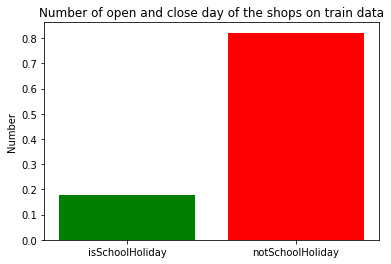

In [23]:
objects = ('isSchoolHoliday', 'notSchoolHoliday')
y_pos = np.arange(len(objects))
length_data = [len(pre_train.Open[pre_train["SchoolHoliday"] == 1])/len(pre_train.Open), len(pre_train.Open[pre_train["SchoolHoliday"] == 0])/len(pre_train.Open)]
 
plt.bar(y_pos, length_data, align='center', alpha=1, color=['green','red'])
plt.xticks(y_pos, objects)
plt.ylabel('Number')
plt.title('Number of open and close day of the shops on train data')
 
plt.show()

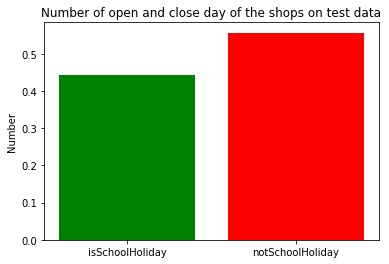

In [24]:
objects = ('isSchoolHoliday', 'notSchoolHoliday')
y_pos = np.arange(len(objects))
length_data = [len(pre_test.Open[pre_test["SchoolHoliday"] == 1])/len(pre_test.Open), len(pre_test.Open[pre_test["SchoolHoliday"] == 0])/len(pre_test.Open)]
 
plt.bar(y_pos, length_data, align='center', alpha=1, color=['green','red'])
plt.xticks(y_pos, objects)
plt.ylabel('Number')
plt.title('Number of open and close day of the shops on test data')
 
plt.show()

In [25]:
type(pre_train.Date.sort_values())

pandas.core.series.Series

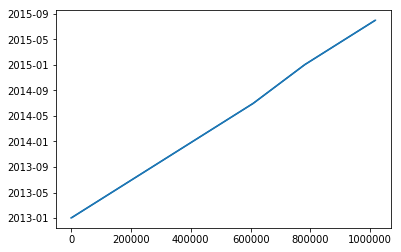

In [26]:
plt.plot(pre_train.Date.sort_values(ascending=True).reset_index(drop=True))
plt.show()

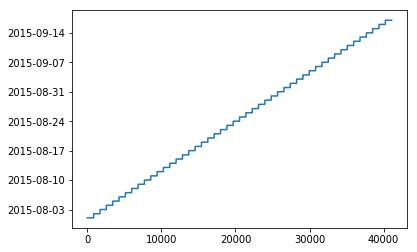

In [27]:
plt.plot(pre_test.Date.sort_values(ascending=True).reset_index(drop=True))
plt.show()

(array([1.72877e+05, 1.07000e+02, 6.20000e+02, 1.89600e+03, 4.13000e+03,
        8.39000e+03, 1.41860e+04, 2.16560e+04, 3.14910e+04, 4.13200e+04,
        4.93110e+04, 5.53090e+04, 5.84920e+04, 5.91820e+04, 5.79320e+04,
        5.40820e+04, 4.93650e+04, 4.49760e+04, 4.12180e+04, 3.56050e+04,
        3.09410e+04, 2.65370e+04, 2.31100e+04, 1.95920e+04, 1.69870e+04,
        1.44620e+04, 1.21680e+04, 1.02250e+04, 8.60900e+03, 7.16100e+03,
        6.04700e+03, 5.08100e+03, 4.37100e+03, 3.73900e+03, 3.23900e+03,
        2.79300e+03, 2.41100e+03, 2.03900e+03, 1.84100e+03, 1.67300e+03,
        1.45600e+03, 1.20800e+03, 1.10900e+03, 1.03500e+03, 9.09000e+02,
        7.95000e+02, 7.42000e+02, 6.14000e+02, 5.48000e+02, 4.85000e+02,
        4.15000e+02, 3.52000e+02, 3.38000e+02, 2.56000e+02, 2.61000e+02,
        2.03000e+02, 1.83000e+02, 1.39000e+02, 9.90000e+01, 1.16000e+02,
        9.20000e+01, 6.70000e+01, 7.10000e+01, 6.10000e+01, 7.30000e+01,
        4.50000e+01, 4.00000e+01, 5.00000e+01, 3.30

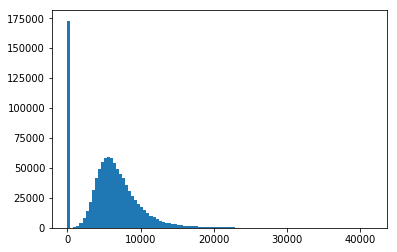

In [28]:
plt.hist(pre_train.Sales,100)

(array([ 2.,  5.,  5.,  6., 14., 11., 18., 16., 21., 37., 29., 42., 37.,
        51., 47., 31., 48., 43., 42., 38., 40., 33., 58., 43., 38., 33.,
        36., 28., 17., 26., 20., 20., 13., 15., 18., 17., 10., 12.,  3.,
        11.,  4.,  8., 10.,  7.,  6.,  1.,  5.,  3.,  2.,  3.,  0.,  0.,
         3.,  2.,  3.,  1.,  1.,  2.,  2.,  1.,  0.,  1.,  0.,  1.,  2.,
         1.,  0.,  2.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  2.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  1.]),
 array([ 2703.73657289,  2894.27404134,  3084.8115098 ,  3275.34897825,
         3465.88644671,  3656.42391516,  3846.96138362,  4037.49885207,
         4228.03632053,  4418.57378898,  4609.11125744,  4799.64872589,
         4990.18619435,  5180.7236628 ,  5371.26113126,  5561.79859971,
         5752.33606817,  5942.87353662,  6133.41100508,  6323.94847353,
         6514.48594199,  6705.02341044,  6895.5608789 ,  7086.09834735,
  

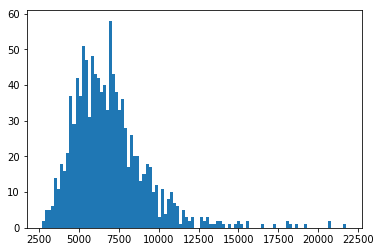

In [29]:
plt.hist(pre_train[pre_train["Sales"] != 0].groupby(['Store']).Sales.mean(),100)

(array([1.72884e+05, 7.30000e+02, 3.77200e+03, 1.47080e+04, 3.54060e+04,
        6.47450e+04, 9.01850e+04, 1.01267e+05, 9.74110e+04, 8.76340e+04,
        7.34540e+04, 5.92830e+04, 4.71420e+04, 3.68090e+04, 2.76340e+04,
        2.12360e+04, 1.55560e+04, 1.20940e+04, 9.26800e+03, 7.24400e+03,
        5.65300e+03, 4.60100e+03, 3.72400e+03, 3.17400e+03, 2.60200e+03,
        2.25900e+03, 1.86300e+03, 1.53900e+03, 1.33000e+03, 1.10100e+03,
        1.01200e+03, 9.10000e+02, 7.83000e+02, 7.00000e+02, 6.44000e+02,
        5.77000e+02, 4.77000e+02, 4.34000e+02, 4.50000e+02, 4.43000e+02,
        4.52000e+02, 4.26000e+02, 5.04000e+02, 4.62000e+02, 4.23000e+02,
        4.02000e+02, 3.74000e+02, 2.79000e+02, 2.44000e+02, 1.80000e+02,
        1.66000e+02, 9.10000e+01, 7.70000e+01, 6.50000e+01, 5.20000e+01,
        5.10000e+01, 3.20000e+01, 2.80000e+01, 3.20000e+01, 1.90000e+01,
        2.50000e+01, 2.00000e+01, 1.80000e+01, 6.00000e+00, 8.00000e+00,
        6.00000e+00, 7.00000e+00, 5.00000e+00, 6.00

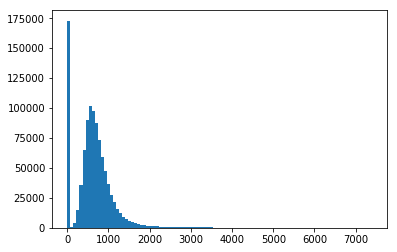

In [30]:
plt.hist(pre_train.Customers,100)

(array([ 2.,  0.,  9., 16., 23., 30., 46., 51., 69., 69., 68., 58., 67.,
        62., 72., 50., 46., 35., 38., 37., 29., 21., 32., 20., 23., 11.,
        14., 13., 14.,  6.,  5.,  6.,  7.,  8.,  4.,  3.,  6.,  1.,  2.,
         1.,  3.,  2.,  4.,  3.,  3.,  1.,  2.,  0.,  4.,  0.,  1.,  0.,
         1.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  1.,  3.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,
         1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  2.]),
 array([ 240.18309859,  271.81585359,  303.44860859,  335.0813636 ,
         366.7141186 ,  398.3468736 ,  429.9796286 ,  461.6123836 ,
         493.2451386 ,  524.8778936 ,  556.51064861,  588.14340361,
         619.77615861,  651.40891361,  683.04166861,  714.67442361,
         746.30717861,  777.93993361,  809.57268862,  841.20544362,
         872.83819862,  904.47095362,  936.10370862,  967.73646362,
         999.36921862, 103

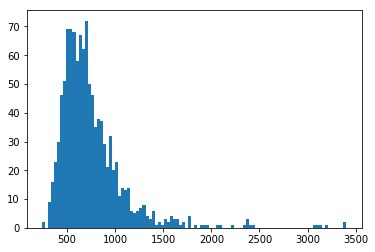

In [31]:
plt.hist(pre_train[pre_train["Sales"] != 0].groupby(['Store']).Customers.mean(),100)

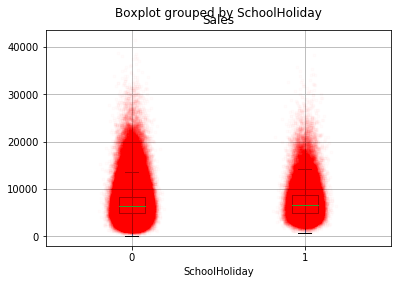

In [60]:
bp = pre_train[pre_train["Sales"] != 0].boxplot(column='Sales', by='SchoolHoliday', grid=True, showfliers=False)
#for i in [0, 1]:
y = pre_train[pre_train["Sales"] != 0].Sales[pre_train.SchoolHoliday==0]
# Add some random "jitter" to the x-axis
x = np.random.normal(1, 0.04, size=len(y))
plt.plot(x, y, 'r.', alpha=0.01)

y = pre_train[pre_train["Sales"] != 0].Sales[pre_train.SchoolHoliday==1]
# Add some random "jitter" to the x-axis
x = np.random.normal(2, 0.04, size=len(y))
plt.plot(x, y, 'r.', alpha=0.01)

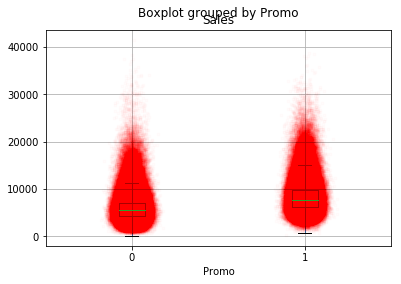

In [61]:
bp = pre_train[pre_train["Sales"] != 0].boxplot(column='Sales', by='Promo', grid=True, showfliers=False)
#for i in [0, 1]:
y = pre_train[pre_train["Sales"] != 0].Sales[pre_train.Promo==0]
# Add some random "jitter" to the x-axis
x = np.random.normal(1, 0.04, size=len(y))
plt.plot(x, y, 'r.', alpha=0.01)

y = pre_train[pre_train["Sales"] != 0].Sales[pre_train.Promo==1]
# Add some random "jitter" to the x-axis
x = np.random.normal(2, 0.04, size=len(y))
plt.plot(x, y, 'r.', alpha=0.01)

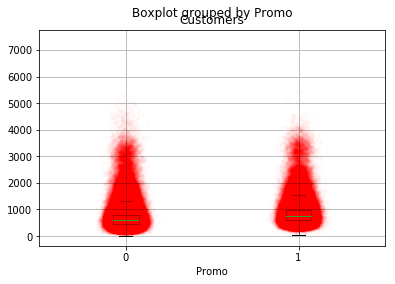

In [63]:
bp = pre_train[pre_train["Customers"] != 0].boxplot(column='Customers', by='Promo', grid=True, showfliers=False)
#for i in [0, 1]:
y = pre_train[pre_train["Customers"] != 0].Customers[pre_train.Promo==0]
# Add some random "jitter" to the x-axis
x = np.random.normal(1, 0.04, size=len(y))
plt.plot(x, y, 'r.', alpha=0.01)

y = pre_train[pre_train["Customers"] != 0].Customers[pre_train.Promo==1]
# Add some random "jitter" to the x-axis
x = np.random.normal(2, 0.04, size=len(y))
plt.plot(x, y, 'r.', alpha=0.01)

In [33]:
[(df["B"] > 50) & (df["C"] == 900)]

NameError: name 'df' is not defined

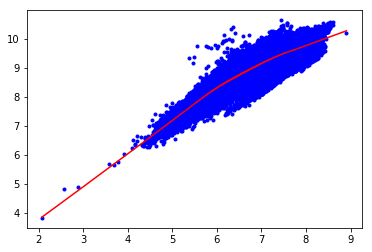

In [330]:
plt.rcParams['agg.path.chunksize'] = 10000
sale_and_customer = pre_train[["Sales","Customers"]][(pre_train["Sales"] != 0) & (pre_train["Customers"] != 0)]

x = np.log(sale_and_customer.Customers)
y = np.log(sale_and_customer.Sales)



plt.plot(x, y, '.b')

filtered = lowess(y, x, is_sorted=False, frac=0.2, it=0)

plt.plot(filtered[:,0], filtered[:,1], 'r')

#p = sp.polyfit(x, y, deg=50)
#y_ = sp.polyval(p, x)

# plot smoothened data
#plt.plot(x, y_, color='b', linewidth=2)

#z = np.polyfit(x, y, 4)
#p = np.poly1d(z)
#plt.plot(x,p(x),"r--")



In [64]:
pre_train[["Sales","Customers"]][(pre_train["Sales"] == 0) & (pre_train["Customers"] != 0)]

,Sales,Customers
478649,0,3
889932,0,5


(array([  4.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   1.,
          1.,   1.,   0.,   2.,   1.,   5.,   1.,   1.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1., 161.,   9.,   1.,
          1.,   1.,   2.,   2.,   3., 259., 476.,  96.,   7.,  11.,  20.,
         14.,   3.,   2.,   5.,   2.,   2.,   1.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([ 10.  ,  13.01,  16.02,  19.03,  22.04,  25.05,  28.06,  31.07,
         34.08,  37.09,  40.1 ,  43.11,  46.12,  49.13,  52.14,  55.15,
         58.16,  61.17,  64.18,  67.19,  70.2 ,  73.21,  76.22,  79.23,
         82.24,  85.25,  88.26,  91.27,  94.28,  97.29, 100.3 , 103.31,
        106.32, 109.33, 112.34

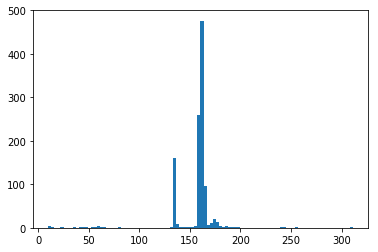

In [93]:
storeWithZeroSales = pre_train[pre_train["Sales"] == 0].groupby(['Store']).Sales.size().sort_values(ascending=False)
plt.hist(storeWithZeroSales,100)

In [94]:
storeWithZeroSales.head()

Store
103    311
708    255
349    242
972    240
674    197
Name: Sales, dtype: int64

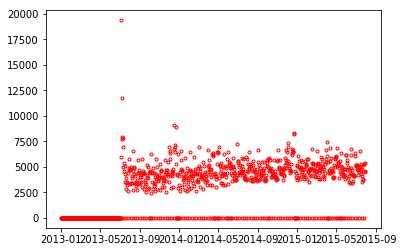

In [136]:
salesByDayStore103 = pre_train[["Sales","Date"]][pre_train["Store"] == 103]

l = plt.plot(salesByDayStore103.Date, salesByDayStore103.Sales,'ro',markerfacecolor='none')
plt.setp(l, markersize=3)
plt.show()

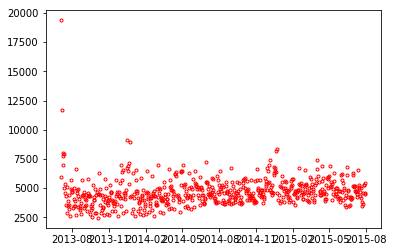

In [142]:
salesByDayStore103 = pre_train[["Sales","Date"]][(pre_train["Store"] == 103) & (pre_train["Open"] == 1)]

l = plt.plot(salesByDayStore103.Date, salesByDayStore103.Sales,'ro',markerfacecolor='none')
plt.setp(l, markersize=3)
plt.show()

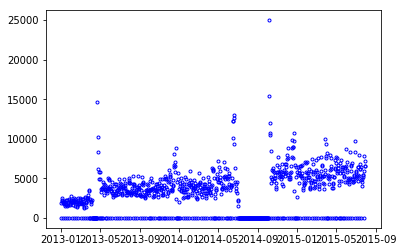

In [137]:
salesByDayStore103 = pre_train[["Sales","Date"]][pre_train["Store"] == 708]

plt.plot(salesByDayStore103.Date, salesByDayStore103.Sales,'.b',markerfacecolor='none')

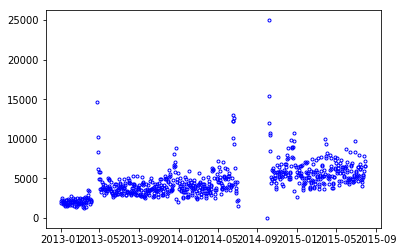

In [143]:
salesByDayStore103 = pre_train[["Sales","Date"]][(pre_train["Store"] == 708) & (pre_train["Open"] == 1)]

plt.plot(salesByDayStore103.Date, salesByDayStore103.Sales,'.b',markerfacecolor='none')

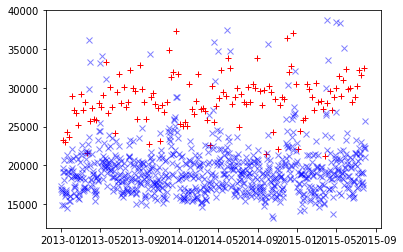

In [161]:
#Highest sale on sunday and doesnot have 0 sales ; 262
salesByDayOnSunday = pre_train[["Sales","Date"]][(pre_train["Store"] == 262) & (pre_train["DayOfWeek"] == 7)]


plt.plot(salesByDayOnSunday.Date, salesByDayOnSunday.Sales, 'r+', alpha=1)



#Highest sale on sunday and doesnot have 0 sales
salesByDayOnSunday = pre_train[["Sales","Date"]][(pre_train["Store"] == 262) & (pre_train["DayOfWeek"] != 7)]

plt.plot(salesByDayOnSunday.Date, salesByDayOnSunday.Sales, 'bx', alpha=0.5)



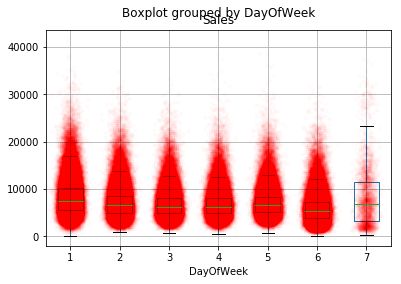

In [174]:
bp = pre_train[pre_train["Sales"] != 0].boxplot(column='Sales', by='DayOfWeek', grid=True, showfliers=False)
#for i in [0, 1]:

y = pre_train[pre_train["Sales"] != 0].Sales[pre_train.DayOfWeek==1]
# Add some random "jitter" to the x-axis
x = np.random.normal(1, 0.1, size=len(y))
plt.plot(x, y, 'r.', alpha=0.01)

y = pre_train[pre_train["Sales"] != 0].Sales[pre_train.DayOfWeek==2]
# Add some random "jitter" to the x-axis
x = np.random.normal(2, 0.1, size=len(y))
plt.plot(x, y, 'r.', alpha=0.01)

y = pre_train[pre_train["Sales"] != 0].Sales[pre_train.DayOfWeek==3]
# Add some random "jitter" to the x-axis
x = np.random.normal(3, 0.1, size=len(y))
plt.plot(x, y, 'r.', alpha=0.01)

y = pre_train[pre_train["Sales"] != 0].Sales[pre_train.DayOfWeek==4]
# Add some random "jitter" to the x-axis
x = np.random.normal(4, 0.1, size=len(y))
plt.plot(x, y, 'r.', alpha=0.01)

y = pre_train[pre_train["Sales"] != 0].Sales[pre_train.DayOfWeek==5]
# Add some random "jitter" to the x-axis
x = np.random.normal(5, 0.1, size=len(y))
plt.plot(x, y, 'r.', alpha=0.01)

y = pre_train[pre_train["Sales"] != 0].Sales[pre_train.DayOfWeek==6]
# Add some random "jitter" to the x-axis
x = np.random.normal(6, 0.1, size=len(y))
plt.plot(x, y, 'r.', alpha=0.01)

y = pre_train[pre_train["Sales"] != 0].Sales[pre_train.DayOfWeek==7]
# Add some random "jitter" to the x-axis
x = np.random.normal(7, 0.1, size=len(y))
plt.plot(x, y, 'r.', alpha=0.01)



# Store Data

In [178]:
store.describe(include='all')

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
count,1115.000000,1115,1115,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000,571
unique,nan,4,3,nan,nan,nan,nan,nan,nan,3
top,nan,a,a,nan,nan,nan,nan,nan,nan,"Jan,Apr,Jul,Oct"
freq,nan,602,593,nan,nan,nan,nan,nan,nan,335
mean,558.000000,NaN,NaN,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573,NaN
std,322.017080,NaN,NaN,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935,NaN
min,1.000000,NaN,NaN,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000,NaN
25%,279.500000,NaN,NaN,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000,NaN
50%,558.000000,NaN,NaN,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000,NaN
75%,836.500000,NaN,NaN,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000,NaN


In [180]:
store.StoreType.value_counts()

a    602
d    348
c    148
b     17
Name: StoreType, dtype: int64

In [183]:
store.Assortment.value_counts()

a    593
c    513
b      9
Name: Assortment, dtype: int64

In [184]:
store.PromoInterval.value_counts()

Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: PromoInterval, dtype: int64

In [194]:
pd.crosstab(store.StoreType,store.Assortment)

Assortment,a,b,c
StoreType,,,
a,381,0,221
b,7,9,1
c,77,0,71
d,128,0,220


In [13]:
len(store.CompetitionDistance.dropna())

1112

(array([290., 146., 114.,  81.,  62.,  51.,  35.,  28.,  24.,  23.,  27.,
         22.,  19.,  11.,  10.,  10.,   8.,  13.,   9.,  12.,   9.,  10.,
         10.,  12.,  11.,   4.,   8.,   5.,   5.,   6.,   1.,   2.,   2.,
          2.,   3.,   3.,   2.,   0.,   2.,   2.,   1.,   1.,   2.,   1.,
          1.,   0.,   1.,   1.,   0.,   0.,   1.,   1.,   0.,   2.,   0.,
          0.,   0.,   0.,   1.,   0.,   1.,   1.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([2.00000e+01, 7.78400e+02, 1.53680e+03, 2.29520e+03, 3.05360e+03,
        3.81200e+03, 4.57040e+03, 5.32880e+03, 6.08720e+03, 6.84560e+03,
        7.60400e+03, 8.36240e+03, 9.12080e+03, 9.87920e+03, 1.06376e+04,
        1.13960e+04, 1.21544e+04, 1.29128e+04, 1.36712e+04, 1.44296e+04,
        1.51880e+04, 1.594

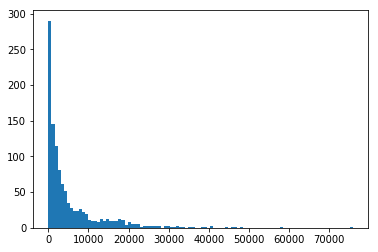

In [12]:
plt.hist(store.CompetitionDistance.dropna(), 100)

In [6]:
monthNullAndYearNotNull = store[["CompetitionOpenSinceMonth", "CompetitionOpenSinceYear"]][(store["CompetitionOpenSinceMonth"].isnull()) & (~store["CompetitionOpenSinceYear"].isnull())]
monthNotNullAndYearNull = store[["CompetitionOpenSinceMonth", "CompetitionOpenSinceYear"]][(~store["CompetitionOpenSinceMonth"].isnull()) & (store["CompetitionOpenSinceYear"].isnull())]

print('monthNullAndYearNotNull', len(monthNullAndYearNotNull))
print('monthNotNullAndYearNull', len(monthNotNullAndYearNull))

monthNullAndYearNotNull 0
monthNotNullAndYearNull 0


In [7]:
distanceNullAndYearNotNull = store[["CompetitionDistance", "CompetitionOpenSinceYear"]][(store["CompetitionDistance"].isnull()) & (~store["CompetitionOpenSinceYear"].isnull())]
distanceNotNullAndYearNull = store[["CompetitionDistance", "CompetitionOpenSinceYear"]][(~store["CompetitionDistance"].isnull()) & (store["CompetitionOpenSinceYear"].isnull())]
print('distanceNullAndYearNotNull', len(distanceNullAndYearNotNull))
print('distanceNotNullAndYearNull', len(distanceNotNullAndYearNull))


distanceNullAndYearNotNull 0
distanceNotNullAndYearNull 351


In [8]:
# some of row have distance but doesn't have year and month
# we have to fix it later.
distanceNotNullAndYearNull.head()

,CompetitionDistance,CompetitionOpenSinceYear
11,1070.000000,NaN
12,310.000000,NaN
15,3270.000000,NaN
18,3240.000000,NaN
21,1040.000000,NaN


In [5]:
competitionOpenYearMonth = store.CompetitionOpenSinceYear.str.cat(store.CompetitionOpenSinceMonth)
competitionOpenYearMonth = pd.to_datetime(competitionOpenYearMonth.dropna(), format='%Y%m', errors='ignore').dt.to_period('M')

In [6]:
competitionOpenYearMonth.head()

0   2008-09
1   2007-11
2   2006-12
3   2009-09
4   2015-04
Name: CompetitionOpenSinceYear, dtype: object

In [82]:
newestCompetitionYearMonth = competitionOpenYearMonth.sort_values(ascending = False).iloc[0]

In [84]:
openSinceInMonth = newestCompetitionYearMonth - competitionOpenYearMonth

(array([ 77.,  87., 105.,  58.,  61.,  72.,  55.,  54.,  70.,  30.,  22.,
         30.,  18.,   9.,   2.,   0.,   0.,   4.,   0.,   0.,   0.,   5.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([   0.  ,   13.87,   27.74,   41.61,   55.48,   69.35,   83.22,
          97.09,  110.96,  124.83,  138.7 ,  152.57,  166.44,  180.31,
         194.18,  208.05,  221.92,  235.79,  249.66,  263.53,  277.4 ,
         291.27,  305.14,  319.01,  332.88,  346.75,  360.62,  374.49,
         388.36,  402.23,  416.1 ,

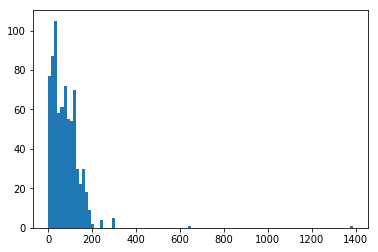

In [85]:
openSinceInMonth = openSinceInMonth.astype('int32')
plt.hist(openSinceInMonth,100)

In [17]:
promoWeekNullAndYearNotNull = store[["Promo2SinceWeek", "Promo2SinceYear"]][(store["Promo2SinceWeek"].isnull()) & (~store["Promo2SinceYear"].isnull())]
promoWeekNotNullAndYearNull = store[["Promo2SinceWeek", "Promo2SinceYear"]][(~store["Promo2SinceWeek"].isnull()) & (store["Promo2SinceYear"].isnull())]

print('promoWeekNullAndYearNotNull', len(promoWeekNullAndYearNotNull))
print('promoWeekNotNullAndYearNull', len(promoWeekNotNullAndYearNull))

promoWeekNullAndYearNotNull 0
promoWeekNotNullAndYearNull 0


In [20]:
promoUseAndYearNull = store[["Promo2", "Promo2SinceYear"]][(store["Promo2"] == 1) & (store["Promo2SinceYear"].isnull())]
promoNotUseAndYearNotNull = store[["Promo2", "Promo2SinceYear"]][(store["Promo2"] == 0) & (~store["Promo2SinceYear"].isnull())]
print('promoUseAndYearNull', len(promoUseAndYearNull))
print('promoNotUseAndYearNotNull', len(promoNotUseAndYearNotNull))


promoUseAndYearNull 0
promoNotUseAndYearNotNull 0


In [145]:
promoUseAndIntervalNull = store[["Promo2", "PromoInterval"]][(store["Promo2"] == 1) & (store["PromoInterval"].isnull())]
promoNotUseAndIntervalNotNull = store[["Promo2", "PromoInterval"]][(store["Promo2"] == 0) & (~store["PromoInterval"].isnull())]
print('promoUseAndIntervalNull', len(promoUseAndIntervalNull))
print('promoNotUseAndIntervalNotNull', len(promoNotUseAndIntervalNotNull))


promoUseAndIntervalNull 0
promoNotUseAndIntervalNotNull 0


In [131]:
promoStartYearMonth = store[(store["Promo2"] == 1)][['Promo2SinceYear','Promo2SinceWeek']]
#Weekday will start on monday.
promoStartYearMonth = pd.to_datetime(promoStartYearMonth.Promo2SinceWeek.astype(str)+
                          promoStartYearMonth.Promo2SinceYear.astype(str).add('-1') ,format='%W%Y-%w')
    


In [132]:
promoStartYearMonth.head()

1    2010-03-29
2    2011-04-04
10   2012-01-02
11   2010-03-29
12   2009-11-09
dtype: datetime64[ns]

In [126]:
type(promoStartYearMonth)

pandas.core.series.Series

In [133]:
newestPromoStartYearMonth = pd.to_datetime(promoStartYearMonth.sort_values(ascending = False).iloc[0])

In [138]:
newestPromoStartYearMonth - promoStartYearMonth

1      1897 days
2      1526 days
10     1253 days
11     1897 days
12     2037 days
13     1344 days
14     1526 days
16     1806 days
17     1162 days
18     1470 days
19      245 days
20     2037 days
21     1106 days
23     1344 days
26     1589 days
27      119 days
29      455 days
31     2037 days
34     1253 days
35      245 days
38      672 days
39     2037 days
40      672 days
41     1344 days
42     2093 days
45     1526 days
46      791 days
50     1561 days
51     1715 days
53      854 days
          ...   
1068   1526 days
1070   1015 days
1071   1953 days
1072    952 days
1073   1526 days
1075    882 days
1076   1743 days
1077   1344 days
1078   2093 days
1079    245 days
1082    854 days
1083   1897 days
1085   1498 days
1087    700 days
1089   1526 days
1091    245 days
1093    245 days
1094   1526 days
1095    455 days
1098    791 days
1099   1526 days
1101    245 days
1102    854 days
1103   1526 days
1104    854 days
1105    672 days
1106   1897 days
1108   1106 da

(array([ 3.,  2.,  4.,  0.,  0.,  1.,  0.,  0.,  1.,  3.,  0., 48.,  0.,
         0.,  0.,  0.,  0.,  1.,  6.,  0.,  1., 32.,  0.,  0.,  3.,  0.,
         1.,  0.,  2., 10.,  0., 37.,  4.,  0.,  1.,  2.,  0.,  7., 10.,
         0., 33., 13.,  0.,  4.,  2., 11.,  0.,  7.,  0.,  1.,  5., 25.,
         0.,  1.,  6.,  0.,  0.,  0., 19.,  0.,  4.,  0., 16.,  0.,  4.,
         0.,  0.,  2.,  8.,  0., 14., 63.,  0., 14.,  3.,  0.,  1.,  1.,
         1.,  0.,  5., 14.,  0.,  0.,  1.,  0.,  0.,  4., 34.,  0.,  0.,
         3.,  0.,  0.,  0., 30.,  0.,  1., 35.,  7.]),
 array([   0.  ,   21.35,   42.7 ,   64.05,   85.4 ,  106.75,  128.1 ,
         149.45,  170.8 ,  192.15,  213.5 ,  234.85,  256.2 ,  277.55,
         298.9 ,  320.25,  341.6 ,  362.95,  384.3 ,  405.65,  427.  ,
         448.35,  469.7 ,  491.05,  512.4 ,  533.75,  555.1 ,  576.45,
         597.8 ,  619.15,  640.5 ,  661.85,  683.2 ,  704.55,  725.9 ,
         747.25,  768.6 ,  789.95,  811.3 ,  832.65,  854.  ,  875.35,
        

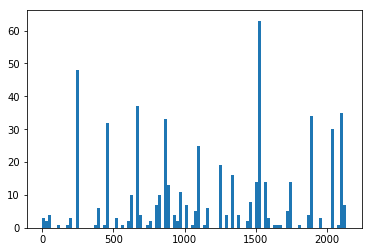

In [141]:
promoSinceInMonth = newestPromoStartYearMonth - promoStartYearMonth
promoSinceInMonth = promoSinceInMonth.astype('timedelta64[D]')
plt.hist(promoSinceInMonth,100)

In [142]:
store.PromoInterval.value_counts()

Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: PromoInterval, dtype: int64

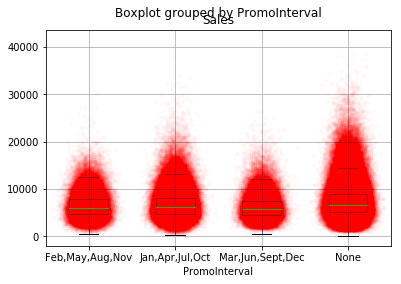

In [378]:
saleAndStore = pd.merge(pre_train, store, on='Store')
saleAndStore = saleAndStore.fillna({'PromoInterval': 'None'})
bp = saleAndStore[saleAndStore["Sales"] != 0].boxplot(column='Sales', by='PromoInterval', grid=True, showfliers=False)
#for i in [0, 1]:




y = saleAndStore[saleAndStore["Sales"] != 0].Sales[saleAndStore.PromoInterval=='Feb,May,Aug,Nov']
# Add some random "jitter" to the x-axis
x = np.random.normal(1, 0.1, size=len(y))
plt.plot(x, y, 'r.', alpha=0.01)

y = saleAndStore[saleAndStore["Sales"] != 0].Sales[saleAndStore.PromoInterval=='Jan,Apr,Jul,Oct']
# Add some random "jitter" to the x-axis
x = np.random.normal(2, 0.1, size=len(y))
plt.plot(x, y, 'r.', alpha=0.01)

y = saleAndStore[saleAndStore["Sales"] != 0].Sales[saleAndStore.PromoInterval=='Mar,Jun,Sept,Dec']
# Add some random "jitter" to the x-axis
x = np.random.normal(3, 0.1, size=len(y))
plt.plot(x, y, 'r.', alpha=0.01)

y = saleAndStore[saleAndStore["Sales"] != 0].Sales[saleAndStore.PromoInterval== 'None']
# Add some random "jitter" to the x-axis
x = np.random.normal(4, 0.1, size=len(y))
plt.plot(x, y, 'r.', alpha=0.01)


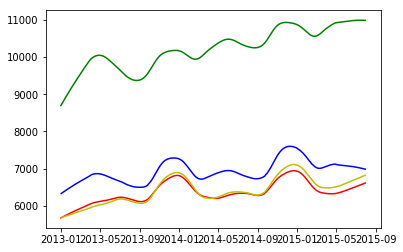

In [299]:
from statsmodels.nonparametric.smoothers_lowess import lowess

saleDateByStore = saleAndStore[(saleAndStore["Sales"] != 0)][["StoreType","Date","Sales"]]
saleDateByStore = saleDateByStore.groupby(['StoreType','Date']).Sales.mean().reset_index()
saleDateByStoreA = saleDateByStore[saleDateByStore["StoreType"] == 'a'][['Date','Sales']]
saleDateByStoreB = saleDateByStore[saleDateByStore["StoreType"] == 'b'][['Date','Sales']]
saleDateByStoreC = saleDateByStore[saleDateByStore["StoreType"] == 'c'][['Date','Sales']]
saleDateByStoreD = saleDateByStore[saleDateByStore["StoreType"] == 'd'][['Date','Sales']]

filteredA = lowess(saleDateByStoreA.Sales, saleDateByStoreA.Date, is_sorted=False, frac=0.2, it=0)
filteredB = lowess(saleDateByStoreB.Sales, saleDateByStoreB.Date, is_sorted=False, frac=0.2, it=0)
filteredC = lowess(saleDateByStoreC.Sales, saleDateByStoreC.Date, is_sorted=False, frac=0.2, it=0)
filteredD = lowess(saleDateByStoreD.Sales, saleDateByStoreD.Date, is_sorted=False, frac=0.2, it=0)

plt.plot(pd.to_datetime(filteredA[:,0]), filteredA[:,1], 'r')
plt.plot(pd.to_datetime(filteredB[:,0]), filteredB[:,1], 'g')
plt.plot(pd.to_datetime(filteredC[:,0]), filteredC[:,1], 'b')
plt.plot(pd.to_datetime(filteredD[:,0]), filteredD[:,1], 'y')

#x_smooth = np.linspace(saleDateByStore.Date.min().value, saleDateByStore.Date.max().value, 100)
#yhat = savitzky_golay(saleDateByStore.Sales, 51, 3)
#plt.plot(x_smooth, yhat,'-b')

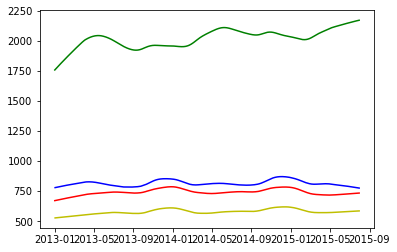

In [301]:
customerDateByStore = saleAndStore[(saleAndStore["Customers"] != 0)][["StoreType","Date","Customers"]]
customerDateByStore = customerDateByStore.groupby(['StoreType','Date']).Customers.mean().reset_index()
customerDateByStoreA = customerDateByStore[customerDateByStore["StoreType"] == 'a'][['Date','Customers']]
customerDateByStoreB = customerDateByStore[customerDateByStore["StoreType"] == 'b'][['Date','Customers']]
customerDateByStoreC = customerDateByStore[customerDateByStore["StoreType"] == 'c'][['Date','Customers']]
customerDateByStoreD = customerDateByStore[customerDateByStore["StoreType"] == 'd'][['Date','Customers']]

filteredA = lowess(customerDateByStoreA.Customers, customerDateByStoreA.Date, is_sorted=False, frac=0.2, it=0)
filteredB = lowess(customerDateByStoreB.Customers, customerDateByStoreB.Date, is_sorted=False, frac=0.2, it=0)
filteredC = lowess(customerDateByStoreC.Customers, customerDateByStoreC.Date, is_sorted=False, frac=0.2, it=0)
filteredD = lowess(customerDateByStoreD.Customers, customerDateByStoreD.Date, is_sorted=False, frac=0.2, it=0)

plt.plot(pd.to_datetime(filteredA[:,0]), filteredA[:,1], 'r')
plt.plot(pd.to_datetime(filteredB[:,0]), filteredB[:,1], 'g')
plt.plot(pd.to_datetime(filteredC[:,0]), filteredC[:,1], 'b')
plt.plot(pd.to_datetime(filteredD[:,0]), filteredD[:,1], 'y')

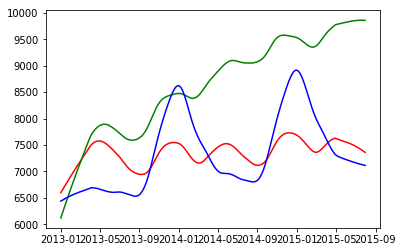

In [305]:
saleDateByAssortment = saleAndStore[(saleAndStore["Sales"] != 0)][["Assortment","Date","Sales"]]
saleDateByAssortment = saleDateByAssortment.groupby(['Assortment','Date']).Sales.mean().reset_index()
saleDateByAssortmentA = saleDateByAssortment[saleDateByAssortment["Assortment"] == 'a'][['Date','Sales']]
saleDateByAssortmentB = saleDateByAssortment[saleDateByAssortment["Assortment"] == 'b'][['Date','Sales']]
saleDateByAssortmentC = saleDateByAssortment[saleDateByAssortment["Assortment"] == 'c'][['Date','Sales']]

filteredA = lowess(saleDateByAssortmentA.Sales, saleDateByAssortmentA.Date, is_sorted=False, frac=0.2, it=0)
filteredB = lowess(saleDateByAssortmentB.Sales, saleDateByAssortmentB.Date, is_sorted=False, frac=0.2, it=0)
filteredC = lowess(saleDateByAssortmentC.Sales, saleDateByAssortmentC.Date, is_sorted=False, frac=0.2, it=0)

plt.plot(pd.to_datetime(filteredA[:,0]), filteredA[:,1], 'r')
plt.plot(pd.to_datetime(filteredB[:,0]), filteredB[:,1], 'g')
plt.plot(pd.to_datetime(filteredC[:,0]), filteredC[:,1], 'b')

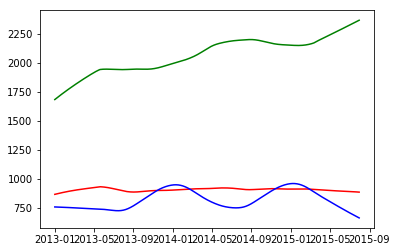

In [310]:
customerDateByAssortment = saleAndStore[(saleAndStore["Customers"] != 0)][["Assortment","Date","Customers"]]
customerDateByAssortment = customerDateByAssortment.groupby(['Assortment','Date']).Customers.mean().reset_index()
customerDateByAssortmentA = customerDateByAssortment[customerDateByAssortment["Assortment"] == 'a'][['Date','Customers']]
customerDateByAssortmentB = customerDateByAssortment[customerDateByAssortment["Assortment"] == 'b'][['Date','Customers']]
customerDateByAssortmentC = customerDateByAssortment[customerDateByAssortment["Assortment"] == 'c'][['Date','Customers']]

filteredA = lowess(customerDateByAssortmentA.Customers, customerDateByAssortmentA.Date, is_sorted=False, frac=0.3, it=0)
filteredB = lowess(customerDateByAssortmentB.Customers, customerDateByAssortmentB.Date, is_sorted=False, frac=0.3, it=0)
filteredC = lowess(customerDateByAssortmentC.Customers, customerDateByAssortmentC.Date, is_sorted=False, frac=0.3, it=0)

plt.plot(pd.to_datetime(filteredA[:,0]), filteredA[:,1], 'r')
plt.plot(pd.to_datetime(filteredB[:,0]), filteredB[:,1], 'g')
plt.plot(pd.to_datetime(filteredC[:,0]), filteredC[:,1], 'b')

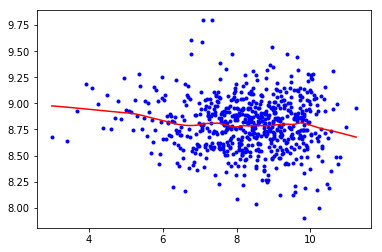

In [328]:
sale_and_distance = saleAndStore[["Sales","CompetitionDistance"]][(saleAndStore["Sales"] != 0) & (~saleAndStore["CompetitionDistance"].isnull())].groupby(['CompetitionDistance']).Sales.mean().reset_index()

x = np.log(sale_and_distance.CompetitionDistance)
y = np.log(sale_and_distance.Sales)

plt.plot(x, y, '.b')

filtered = lowess(y, x, is_sorted=False, frac=0.3, it=0)

plt.plot(filtered[:,0], filtered[:,1], 'r')

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


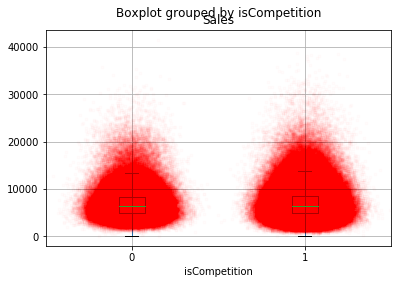

In [361]:
SalesAndCompetition = saleAndStore[['Sales','CompetitionOpenSinceYear']]

SalesAndCompetition['isCompetition'] = np.where(~SalesAndCompetition['CompetitionOpenSinceYear'].isnull(), 1, 0)

#data.loc[data['id'] > 2000, "first_name"] = "John"

#SalesAndCompetition.loc[:,idx['A',:]]<0

#SalesAndCompetition.columns = ['Sales', 'isCompetition']
#SalesAndCompetition = SalesAndCompetition.rename(index=str, columns={"CompetitionOpenSinceYear": "isCompetition"})

bp = SalesAndCompetition[SalesAndCompetition["Sales"] != 0].boxplot(column='Sales', by='isCompetition', grid=True, showfliers=False)

y = saleAndStore[SalesAndCompetition["Sales"] != 0].Sales[SalesAndCompetition.isCompetition==0]
# Add some random "jitter" to the x-axis
x = np.random.normal(1, 0.1, size=len(y))
plt.plot(x, y, 'r.', alpha=0.01)

y = saleAndStore[SalesAndCompetition["Sales"] != 0].Sales[SalesAndCompetition.isCompetition==1]
# Add some random "jitter" to the x-axis
x = np.random.normal(2, 0.1, size=len(y))
plt.plot(x, y, 'r.', alpha=0.01)


In [ ]:
saleAndStore[saleAndStore['CompetitionOpenSinceYear'].isnull()]['Store'].nunique()

In [393]:
saleAndCompetitionBeforeAfter = saleAndStore[~saleAndStore['CompetitionOpenSinceYear'].isnull()][['Store','Date','CompetitionOpenSinceYear','CompetitionOpenSinceMonth','Sales']]

In [470]:
competitionOpenYearMonth = saleAndCompetitionBeforeAfter.CompetitionOpenSinceYear.str.cat(saleAndCompetitionBeforeAfter.CompetitionOpenSinceMonth)
saleAndCompetitionBeforeAfter['competitionOpenYearMonth'] = pd.to_datetime(competitionOpenYearMonth.dropna(), format='%Y%m', errors='ignore')
saleAndCompetitionBeforeAfter['competitionOpenYearMonthBefore'] = saleAndCompetitionBeforeAfter['competitionOpenYearMonth'] + pd.DateOffset(months=-5)
saleAndCompetitionBeforeAfter['competitionOpenYearMonthAfter'] = saleAndCompetitionBeforeAfter['competitionOpenYearMonth'] + pd.DateOffset(months=5)


In [446]:
competitionOpenYearMonth.head()

0    20089
1    20089
2    20089
3    20089
4    20089
Name: CompetitionOpenSinceYear, dtype: object

In [448]:
len(saleAndCompetitionBeforeAfter)

693861

In [471]:
result = saleAndCompetitionBeforeAfter[['Store', 'Date', 'Sales','competitionOpenYearMonth']][((saleAndCompetitionBeforeAfter['Date'] >= saleAndCompetitionBeforeAfter['competitionOpenYearMonthBefore']) & (saleAndCompetitionBeforeAfter['Date'] <= saleAndCompetitionBeforeAfter['competitionOpenYearMonthAfter'])) & (saleAndCompetitionBeforeAfter['Sales']!=0)]



In [453]:
len(result)

18353

In [454]:
(result.Date - result.competitionOpenYearMonth).dt.days.head()

3828    61
3830    59
3831    58
3832    57
3833    56
dtype: int64

In [467]:
filtered[:,1]

array([7629.83800014, 7629.83800014, 7629.83800014, ..., 6832.41211171,
       6832.41211171, 6832.41211171])

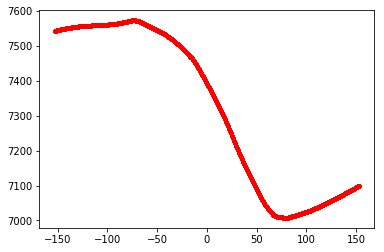

In [472]:
filtered = lowess(result.Sales, (result.Date - result.competitionOpenYearMonth).dt.days, is_sorted=False, frac=0.5, it=0)

plt.plot(filtered[:,0], filtered[:,1], '.r')

In [476]:
saleAndDate = saleAndStore[['Sales','Date']][saleAndStore['Sales'] != 0]

In [480]:
saleAndDate.Date.dt.month.head()

0    7
1    7
2    7
3    7
4    7
Name: Date, dtype: int64

In [487]:
len(saleAndDate)

844338

In [490]:
saleAndDate.groupby(pd.Grouper(key='Date', freq='M')).mean()

,Sales
Date,
2013-01-31,6240.506045
2013-02-28,6428.838730
2013-03-31,7213.092718
2013-04-30,6579.791664
2013-05-31,7077.028245
2013-06-30,6467.745839
2013-07-31,6923.613645
2013-08-31,6596.367019
2013-09-30,6363.615547


In [513]:
saleByMonth = saleAndDate.groupby(saleAndDate['Date'].dt.strftime('%m'))['Sales'].mean().sort_index(level="Date", ascending=True)

AttributeError: 'Series' object has no attribute 'Date'

In [522]:
saleByMonth.keys()

Index(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], dtype='object', name='Date')

<Container object of 12 artists>

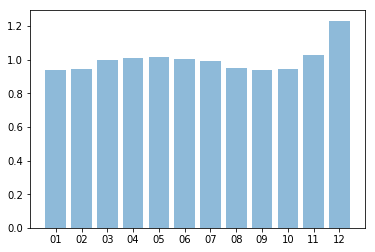

In [526]:
#ax = plt.bar(saleByMonth)
plt.bar(saleByMonth.keys(), saleByMonth / np.mean(saleByMonth), align='center', alpha=0.5)

In [369]:
saleAndStore[['Date', 'Store']][saleAndStore['CompetitionOpenSinceYear'].isnull()].nunique()

Date     942
Store    354
dtype: int64

In [381]:
SalesAndCompetition.head()

,Sales,CompetitionOpenSinceYear,isCompetition
0,5263,2008,1
1,5020,2008,1
2,4782,2008,1
3,5011,2008,1
4,6102,2008,1


In [318]:
saleAndStore = saleAndStore[['Sales','CompetitionOpen']]
saleAndStore = saleAndStore.fillna({'CompetitionOpenSinceYear': 'None'})
bp = saleAndStore[saleAndStore["Sales"] != 0].boxplot(column='Sales', by='PromoInterval', grid=True, showfliers=False)
#for i in [0, 1]:


y = saleAndStore[saleAndStore["Sales"] != 0].Sales[saleAndStore.PromoInterval=='Feb,May,Aug,Nov']
# Add some random "jitter" to the x-axis
x = np.random.normal(1, 0.1, size=len(y))
plt.plot(x, y, 'r.', alpha=0.01)

y = saleAndStore[saleAndStore["Sales"] != 0].Sales[saleAndStore.PromoInterval=='Jan,Apr,Jul,Oct']
# Add some random "jitter" to the x-axis
x = np.random.normal(2, 0.1, size=len(y))
plt.plot(x, y, 'r.', alpha=0.01)

y = saleAndStore[saleAndStore["Sales"] != 0].Sales[saleAndStore.PromoInterval=='Mar,Jun,Sept,Dec']
# Add some random "jitter" to the x-axis
x = np.random.normal(3, 0.1, size=len(y))
plt.plot(x, y, 'r.', alpha=0.01)

y = saleAndStore[saleAndStore["Sales"] != 0].Sales[saleAndStore.PromoInterval== 'None']
# Add some random "jitter" to the x-axis
x = np.random.normal(4, 0.1, size=len(y))
plt.plot(x, y, 'r.', alpha=0.01)


,Sales,CompetitionDistance
0,5263,1270.000000
1,5020,1270.000000
2,4782,1270.000000
3,5011,1270.000000
4,6102,1270.000000


In [327]:
len(filtered[:,0])

654

In [382]:
saleAndStore.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.000000,9,2008,0,NaN,NaN,None
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.000000,9,2008,0,NaN,NaN,None
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.000000,9,2008,0,NaN,NaN,None
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.000000,9,2008,0,NaN,NaN,None
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.000000,9,2008,0,NaN,NaN,None


In [386]:
saleAndStore[saleAndStore['CompetitionOpenSinceYear'].isnull()]['Store'].nunique()

354

In [264]:
saleDateByStore.head()

,StoreType,Date,Sales
0,a,2013-01-01,2907.000000
1,a,2013-01-02,6512.269103
2,a,2013-01-03,5870.261231
3,a,2013-01-04,6007.013311
4,a,2013-01-05,4940.978333


In [276]:
saleDateByStore.Date.min().value

1356998400000000000

In [272]:
x_smooth = np.linspace(saleDateByStore.Date.min(), saleDateByStore.Date.max(), 100)

TypeError: unsupported operand type(s) for *: 'Timestamp' and 'float'

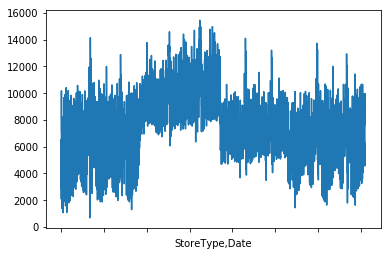

In [260]:
saleDateByStore.plot()

In [275]:
start = pd.Timestamp('2012-01-01')

end = pd.Timestamp('2012-02-01')

np.linspace(start.value, end.value, 10)

array([1.3253760e+18, 1.3256736e+18, 1.3259712e+18, 1.3262688e+18,
       1.3265664e+18, 1.3268640e+18, 1.3271616e+18, 1.3274592e+18,
       1.3277568e+18, 1.3280544e+18])

In [167]:
print('train data: ', pre_train.columns[pre_train.isnull().any()])
print('test data: ', pre_test.columns[pre_test.isnull().any()])
print('store: ', store.columns[store.isnull().any()])

train data:  Index([], dtype='object')
test data:  Index(['Open'], dtype='object')
store:  Index(['CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear',
       'PromoInterval'],
      dtype='object')


In [168]:
# get only rows that the shops are open
pre_train[pre_train["Open"] == 0].head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
291,292,5,2015-07-31,0,0,0,1,0,1
875,876,5,2015-07-31,0,0,0,1,0,1
1406,292,4,2015-07-30,0,0,0,1,0,1
1990,876,4,2015-07-30,0,0,0,1,0,1
2521,292,3,2015-07-29,0,0,0,1,0,1


In [169]:
# train data
# remove the row that shops are closed
pre_train = pre_train[pre_train["Open"] != 0]

In [170]:
pre_test.columns[pre_test.isnull().any()]

Index(['Open'], dtype='object')

In [172]:
pre_test[pre_test["Open"].isnull()]
# only store ID = 622 contain nan value on Open field.

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
479,480,622,4,2015-09-17,nan,1,0,0
1335,1336,622,3,2015-09-16,nan,1,0,0
2191,2192,622,2,2015-09-15,nan,1,0,0
3047,3048,622,1,2015-09-14,nan,1,0,0
4759,4760,622,6,2015-09-12,nan,0,0,0
5615,5616,622,5,2015-09-11,nan,0,0,0
6471,6472,622,4,2015-09-10,nan,0,0,0
7327,7328,622,3,2015-09-09,nan,0,0,0
8183,8184,622,2,2015-09-08,nan,0,0,0
9039,9040,622,1,2015-09-07,nan,0,0,0


In [153]:
# test data
# Open column in test data contains NA value 
# Assume that all of them are open
pre_test.fillna(1, inplace=True)

Index([], dtype='object')

In [24]:
# Merge with store data
pre_train = pd.merge(pre_train, store, on='Store')
pre_test = pd.merge(pre_test, store, on='Store')

In [25]:
# Gather some features
# I will pick only top 8 features
# https://www.kaggle.com/cast42/xgboost-in-python-with-rmspe-v2/code
# Day, Store, Competition Open, WeekOfYear, DayOfWeek, PromoOpen, CompetitionDistance, Month
def build_features(features, data):
    # remove NaNs
    data.fillna(0, inplace=True)
    data.loc[data.Open.isnull(), 'Open'] = 1
    # Use some properties directly
    
    features.extend(['Store', 'CompetitionDistance'])
    
    features.append('DayOfWeek')
    features.append('Month')
    features.append('Day')
    features.append('WeekOfYear')
    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    data['WeekOfYear'] = data.Date.dt.weekofyear

    
    # CompetionOpen en PromoOpen from https://www.kaggle.com/ananya77041/rossmann-store-sales/randomforestpython/code
    # Calculate time competition open time in months
    #features.append('CompetitionOpen')
    #data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) + \
    #    (data.Month - data.CompetitionOpenSinceMonth)
    # Promo open time in months
    features.append('PromoOpen')
    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) + \
        (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
    data['PromoOpen'] = data.PromoOpen.apply(lambda x: x if x > 0 else 0)
    data.loc[data.Promo2SinceYear == 0, 'PromoOpen'] = 0

In [26]:
features = []

print("augment features")
build_features(features, pre_train)
build_features([], pre_test)
print(features)

augment features
['Store', 'CompetitionDistance', 'DayOfWeek', 'Month', 'Day', 'WeekOfYear', 'PromoOpen']


In [27]:
pre_train[0:5]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,PromoOpen
0,1,5,2015-07-31,5263,555,1,1,0,1.0,c,...,2008.0,0,0.0,0.0,0,2015,7,31,31,0.0
1,1,4,2015-07-30,5020,546,1,1,0,1.0,c,...,2008.0,0,0.0,0.0,0,2015,7,30,31,0.0
2,1,3,2015-07-29,4782,523,1,1,0,1.0,c,...,2008.0,0,0.0,0.0,0,2015,7,29,31,0.0
3,1,2,2015-07-28,5011,560,1,1,0,1.0,c,...,2008.0,0,0.0,0.0,0,2015,7,28,31,0.0
4,1,1,2015-07-27,6102,612,1,1,0,1.0,c,...,2008.0,0,0.0,0.0,0,2015,7,27,31,0.0


In [28]:
#train = pre_train[['Store', 'CompetitionDistance', 'DayOfWeek', 'Month', 'Day', 'WeekOfYear', 'CompetitionOpen', 'PromoOpen', 'Sales']]
train = pre_train[['Store', 'CompetitionDistance', 'DayOfWeek', 'Month', 'Day', 'WeekOfYear', 'PromoOpen', 'Sales']]
train[0:5]

,Store,CompetitionDistance,DayOfWeek,Month,Day,WeekOfYear,PromoOpen,Sales
0,1,1270.0,5,7,31,31,0.0,5263
1,1,1270.0,4,7,30,31,0.0,5020
2,1,1270.0,3,7,29,31,0.0,4782
3,1,1270.0,2,7,28,31,0.0,5011
4,1,1270.0,1,7,27,31,0.0,6102


In [29]:
#test = pre_test[['Store', 'CompetitionDistance', 'DayOfWeek', 'Month', 'Day', 'WeekOfYear', 'CompetitionOpen', 'PromoOpen']]
test = pre_test[['Store', 'CompetitionDistance', 'DayOfWeek', 'Month', 'Day', 'WeekOfYear', 'PromoOpen']]
test[0:5]

,Store,CompetitionDistance,DayOfWeek,Month,Day,WeekOfYear,PromoOpen
0,1,1270.0,4,9,17,38,0.0
1,1,1270.0,3,9,16,38,0.0
2,1,1270.0,2,9,15,38,0.0
3,1,1270.0,1,9,14,38,0.0
4,1,1270.0,7,9,13,37,0.0


In [30]:
#train_data = train[['Store', 'CompetitionDistance', 'DayOfWeek', 'Month', 'Day', 'WeekOfYear', 'CompetitionOpen', 'PromoOpen']]
train_data = train[['Store', 'CompetitionDistance', 'DayOfWeek', 'Month', 'Day', 'WeekOfYear', 'PromoOpen']]
train_target = train[['Sales']]

In [31]:
X_train, X_test, y_train, y_test = train_test_split(train_data, train_target, test_size=0.2, random_state=0)

# Prediction

In [32]:
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [33]:
def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

In [34]:
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

In [35]:
polynomial_features = PolynomialFeatures(degree=2,
                                             include_bias=False)
linear_regression = LinearRegression()
pipeline = Pipeline([("polynomial_features", polynomial_features),
                     ("linear_regression", linear_regression)])
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

In [36]:
rmspe(y_test, y_pred)

Sales    0.421337
dtype: float64

In [37]:
X_test[1:5]

,Store,CompetitionDistance,DayOfWeek,Month,Day,WeekOfYear,PromoOpen
804488,1065,1290.0,4,3,6,10,29.75
21470,29,2170.0,4,3,5,10,0.00
652541,864,1020.0,2,3,3,10,63.25
355557,470,50.0,2,4,2,14,0.00


In [38]:
y_pred[1:5]

array([[6070.82177107],
       [7052.57985193],
       [8004.27102535],
       [8728.01653907]])